In [1]:
import sys
sys.path.append("../../")
import warnings
warnings.simplefilter(action="ignore")

In [2]:
import numpy as np
import seaborn as sns
import pandas as pd
import polars as pl
from functions.eda import *
from functions.cat_eda import *
from functions.num_eda import *

In [3]:
data=pl.read_csv("CarPrice_Assignment.csv").drop(["car_ID","CarName"])
data

symboling,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,carheight,curbweight,enginetype,cylindernumber,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
i64,str,str,str,str,str,str,f64,f64,f64,f64,i64,str,str,i64,str,f64,f64,f64,i64,i64,i64,i64,f64
3,"""gas""","""std""","""two""","""convertible""","""rwd""","""front""",88.6,168.8,64.1,48.8,2548,"""dohc""","""four""",130,"""mpfi""",3.47,2.68,9.0,111,5000,21,27,13495.0
3,"""gas""","""std""","""two""","""convertible""","""rwd""","""front""",88.6,168.8,64.1,48.8,2548,"""dohc""","""four""",130,"""mpfi""",3.47,2.68,9.0,111,5000,21,27,16500.0
1,"""gas""","""std""","""two""","""hatchback""","""rwd""","""front""",94.5,171.2,65.5,52.4,2823,"""ohcv""","""six""",152,"""mpfi""",2.68,3.47,9.0,154,5000,19,26,16500.0
2,"""gas""","""std""","""four""","""sedan""","""fwd""","""front""",99.8,176.6,66.2,54.3,2337,"""ohc""","""four""",109,"""mpfi""",3.19,3.4,10.0,102,5500,24,30,13950.0
2,"""gas""","""std""","""four""","""sedan""","""4wd""","""front""",99.4,176.6,66.4,54.3,2824,"""ohc""","""five""",136,"""mpfi""",3.19,3.4,8.0,115,5500,18,22,17450.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
-1,"""gas""","""std""","""four""","""sedan""","""rwd""","""front""",109.1,188.8,68.9,55.5,2952,"""ohc""","""four""",141,"""mpfi""",3.78,3.15,9.5,114,5400,23,28,16845.0
-1,"""gas""","""turbo""","""four""","""sedan""","""rwd""","""front""",109.1,188.8,68.8,55.5,3049,"""ohc""","""four""",141,"""mpfi""",3.78,3.15,8.7,160,5300,19,25,19045.0
-1,"""gas""","""std""","""four""","""sedan""","""rwd""","""front""",109.1,188.8,68.9,55.5,3012,"""ohcv""","""six""",173,"""mpfi""",3.58,2.87,8.8,134,5500,18,23,21485.0


Check for Linearity between independent variables and dependent variable

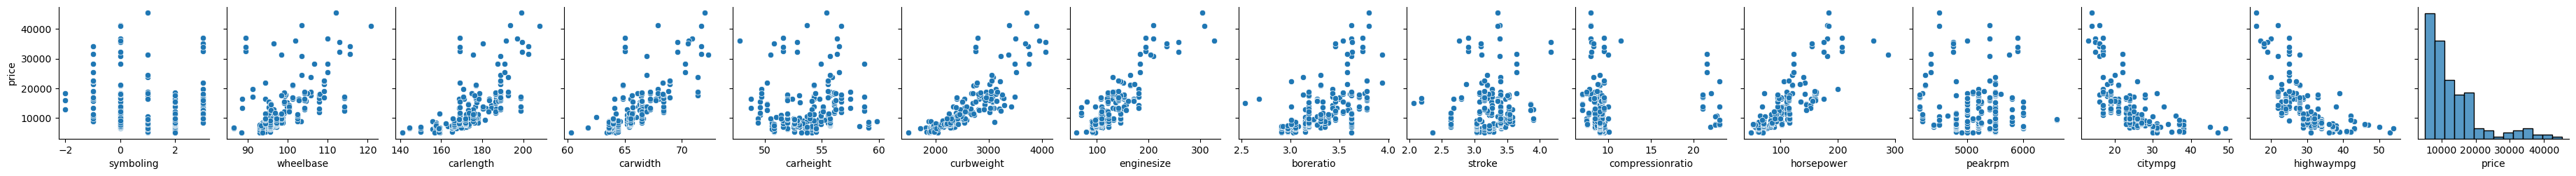

In [4]:
sns.pairplot(data.to_pandas(),y_vars=["price"])
plt.show()

Missing Values

In [5]:
data.null_count().sum()

symboling,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,carheight,curbweight,enginetype,cylindernumber,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


No missing

In [6]:
cat_cols=[col for col in data.columns if data[col].dtype== pl.String]
num_cols=[col for col in data.columns if data[col].dtype!= pl.String]

# Categorical EDA

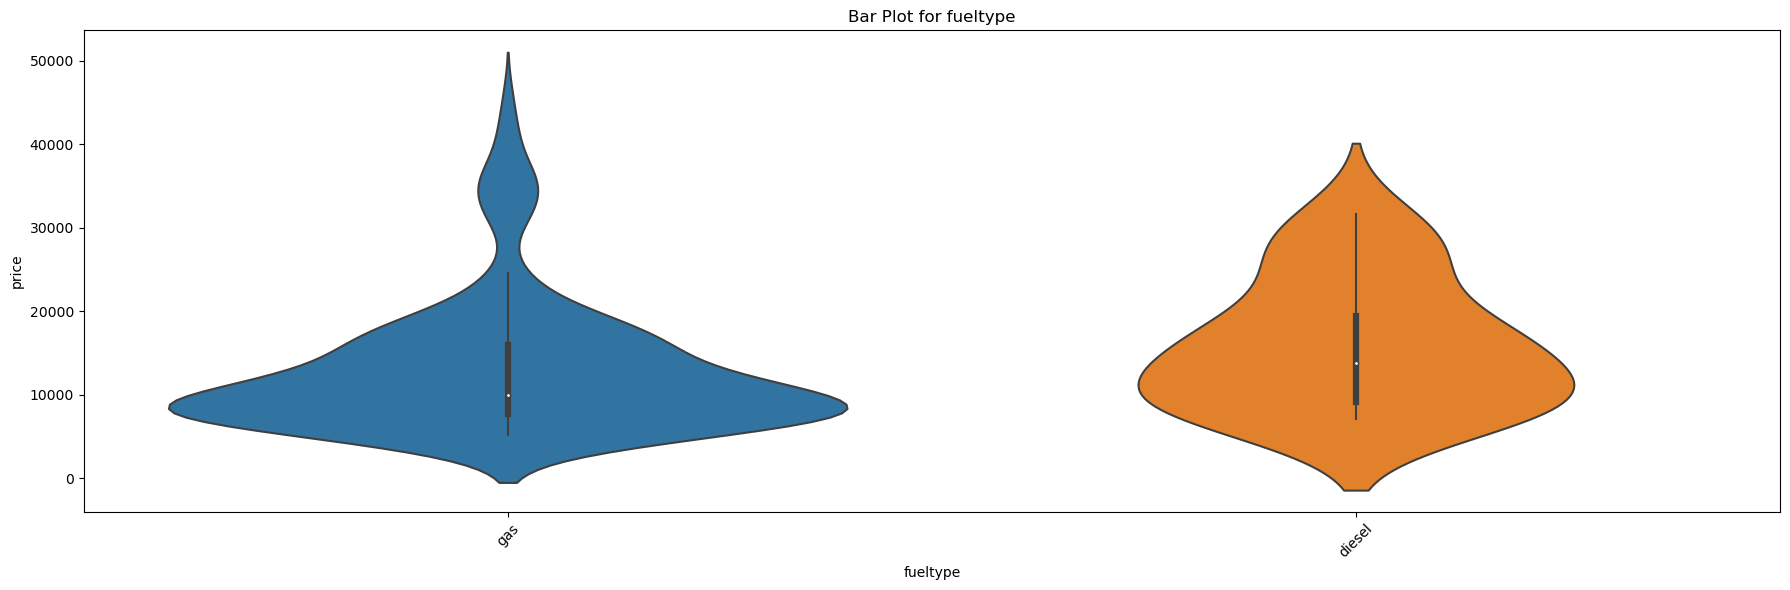

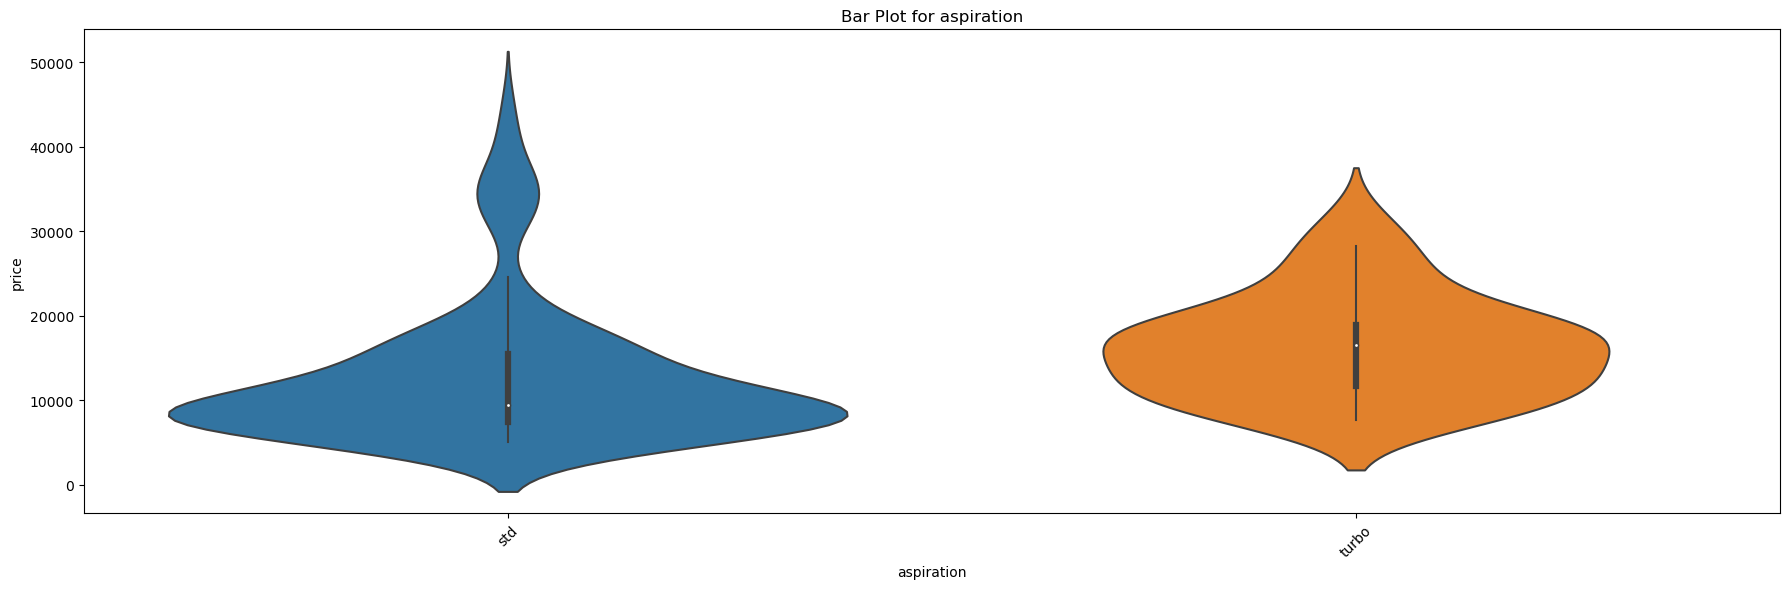

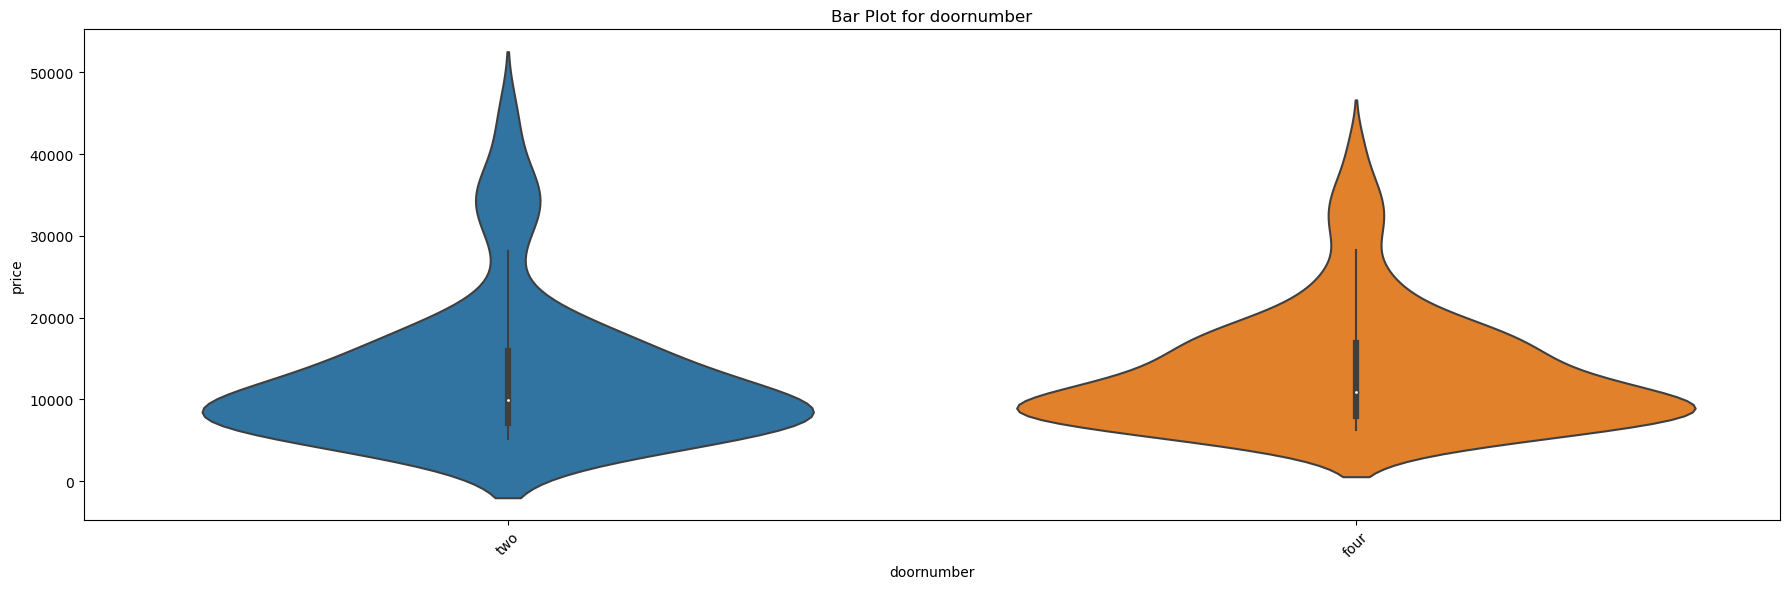

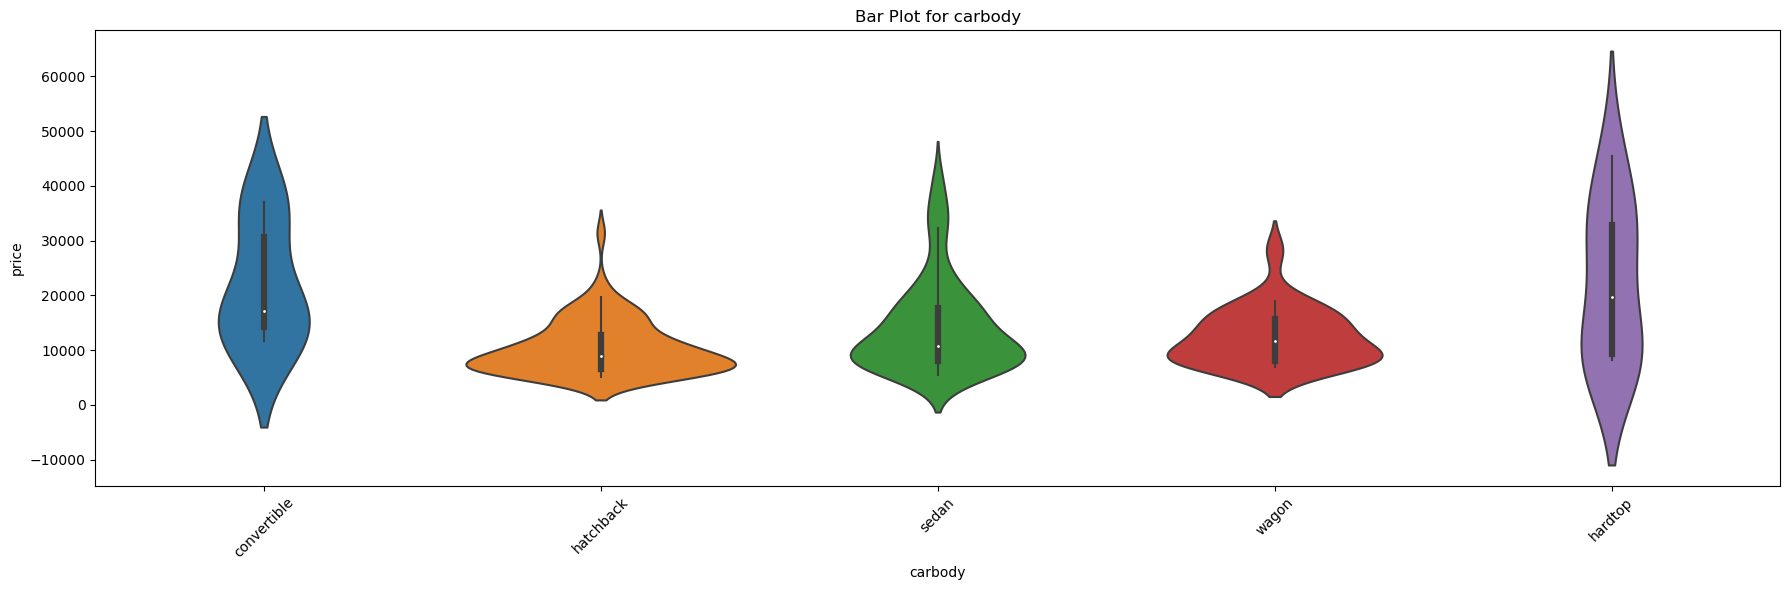

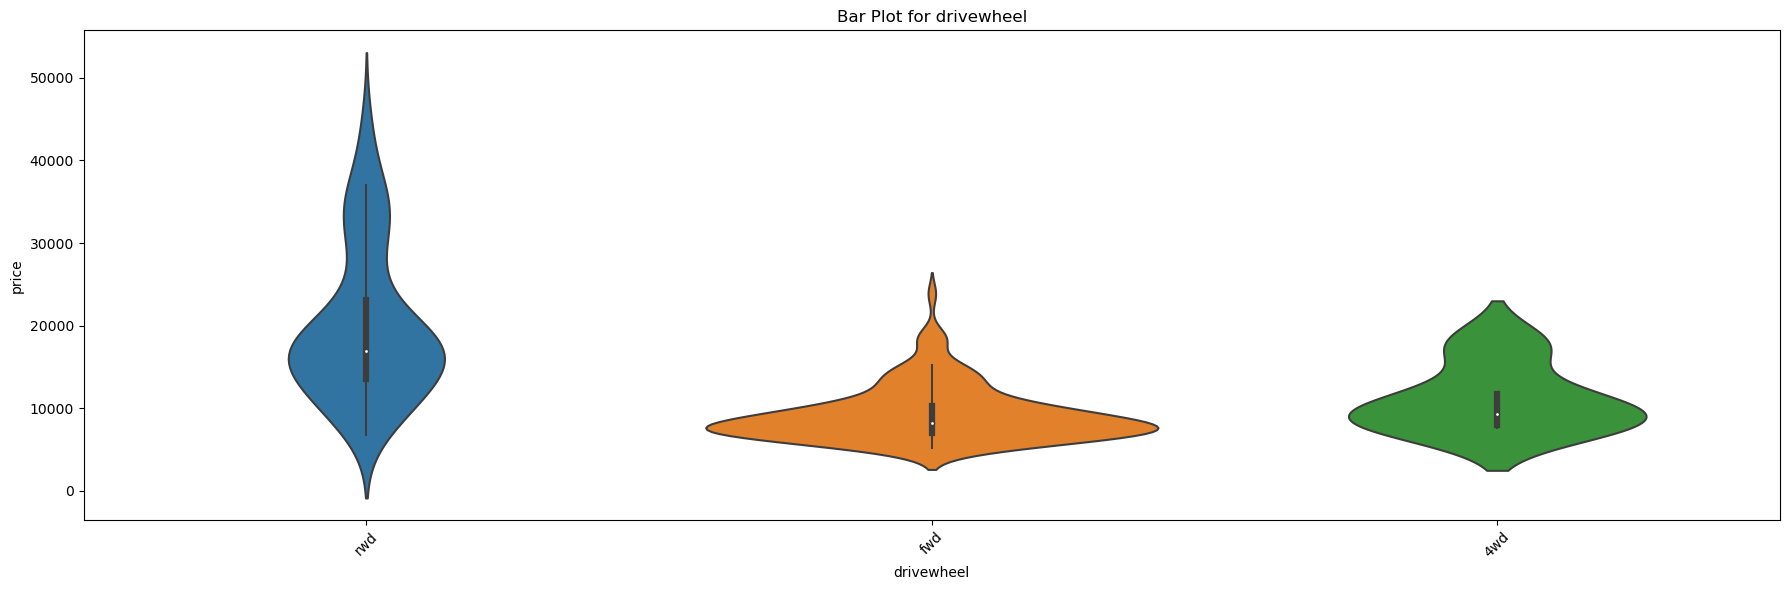

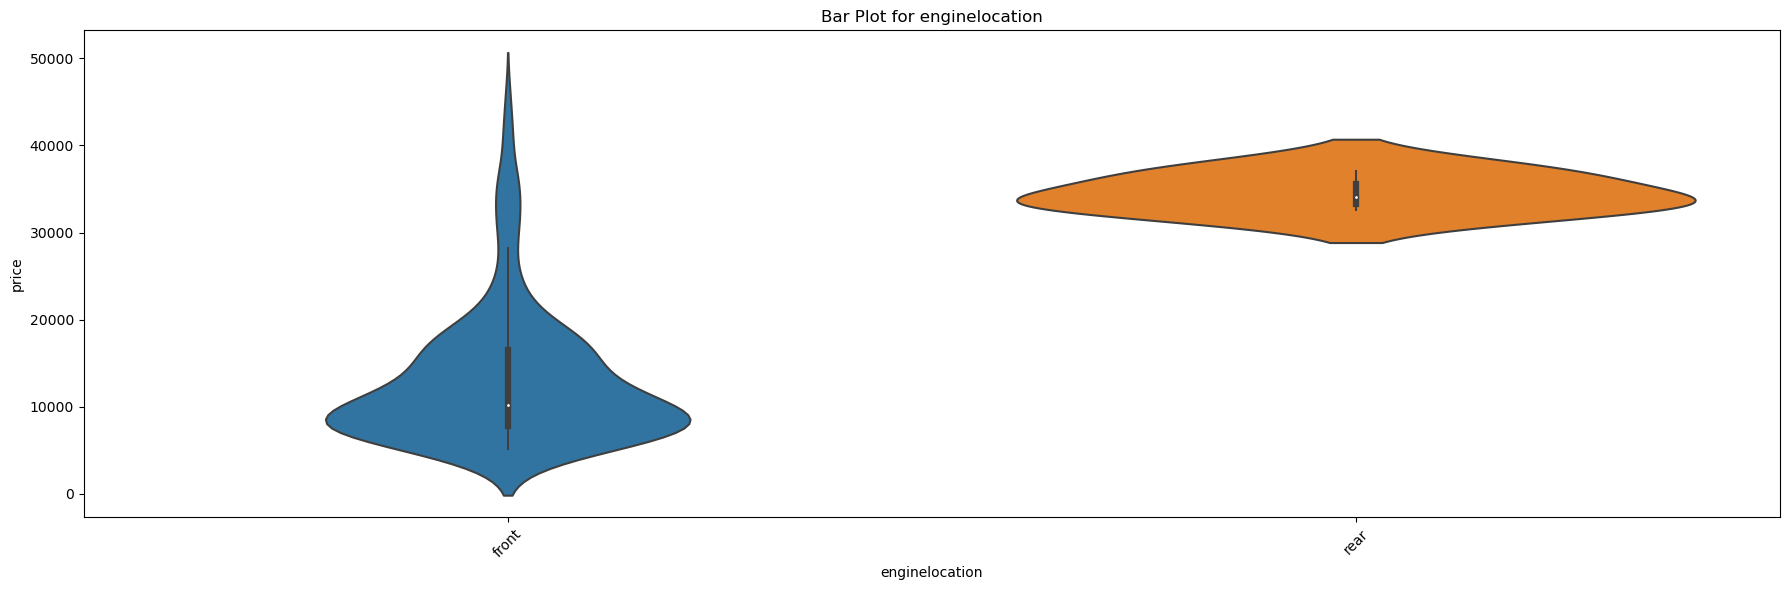

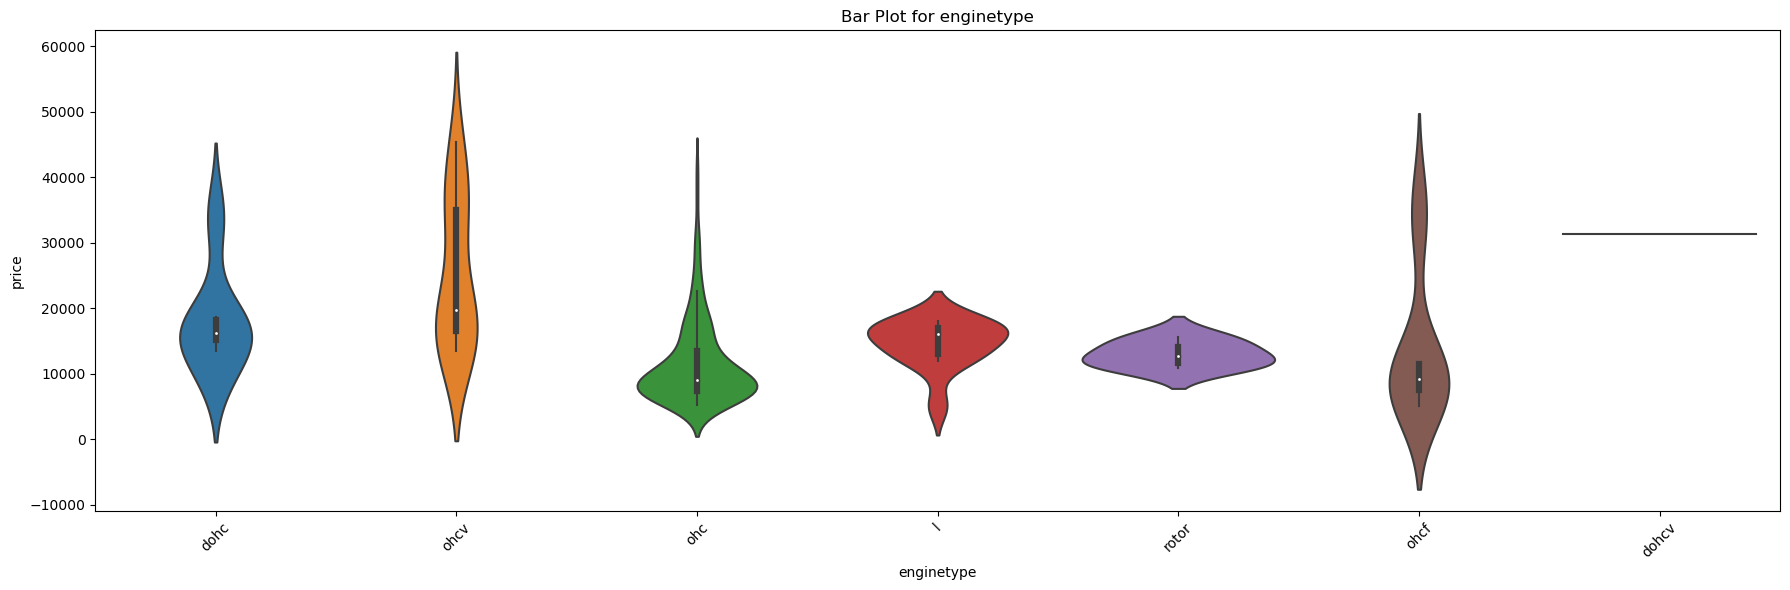

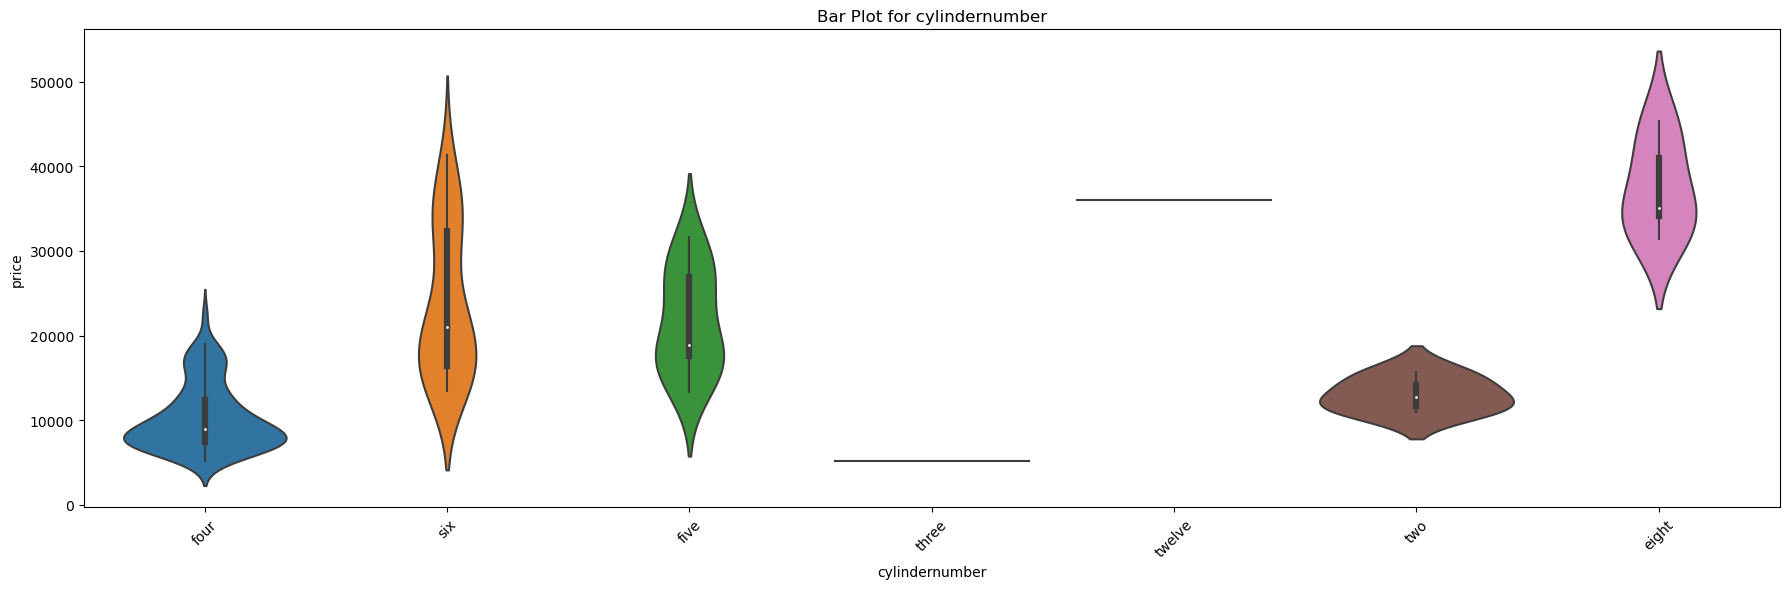

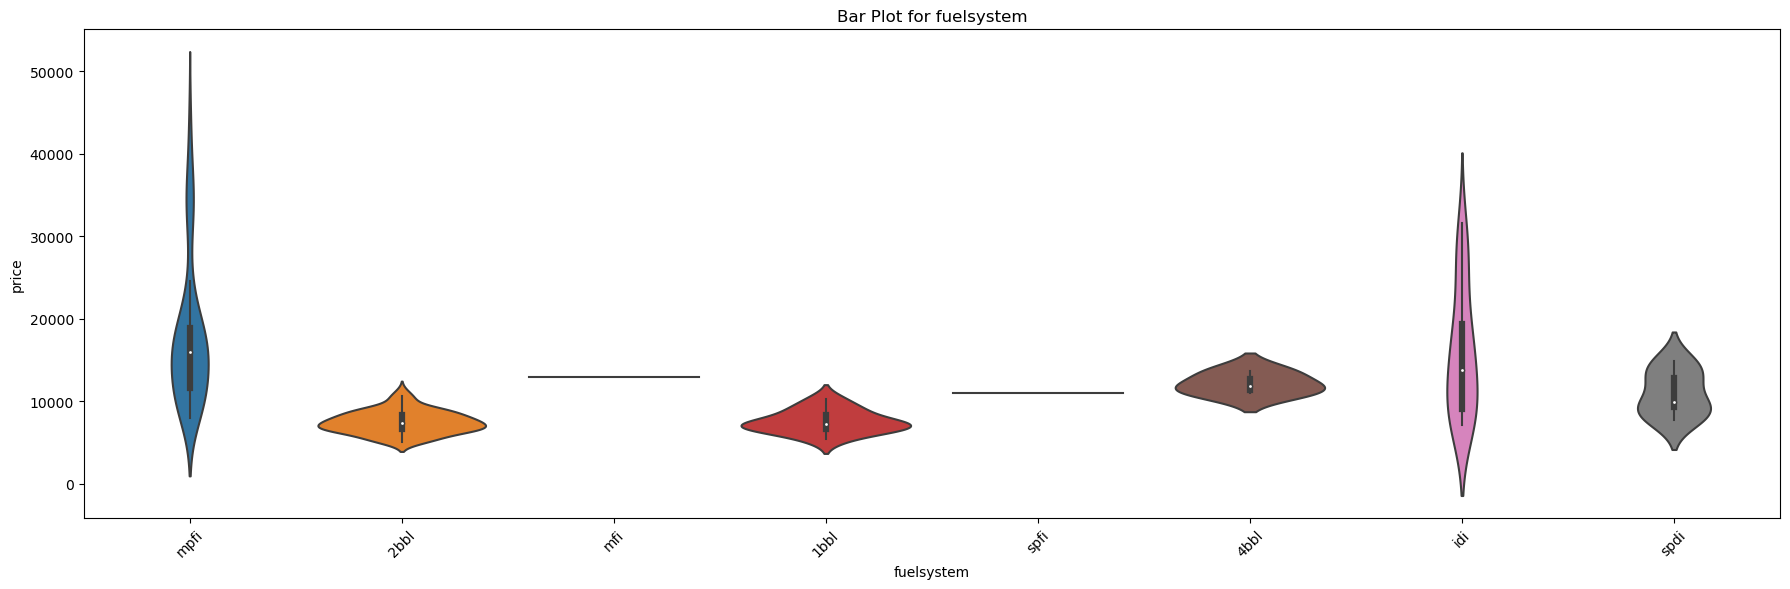

In [7]:
categorical_violin_plot(data.to_pandas(),cat_cols,"price")

indepedent t test for binary categories

In [8]:
perform_ttest(data, "fueltype", "gas", "diesel","price")
perform_ttest(data, "aspiration", "std", "turbo","price")
perform_ttest(data, "doornumber", "two", "four","price")
perform_ttest(data, "enginelocation", "front", "rear","price")

T-statistic: -1.5495186834799177
P-value: 0.1345832569726233
There is no significant difference in price between gas and diesel for column 'fueltype'.
T-statistic: -3.1082912587021956
P-value: 0.0027444703520030996
There is a significant difference in price between std and turbo for column 'aspiration'.
T-statistic: -0.44402122752783313
P-value: 0.6575834833124052
There is no significant difference in price between two and four for column 'doornumber'.
T-statistic: -15.112667410064798
P-value: 0.0010792790448390808
There is a significant difference in price between front and rear for column 'enginelocation'.


Dropping doornumber,fueltype

In [9]:
data=data.drop("fueltype")
data=data.drop("doornumber")
cat_cols.remove("fueltype")
cat_cols.remove("doornumber")

Performing Kruskal-Walli test instead of ANOVA as data not following normal distribution

In [10]:
perform_non_normal_kruskal_hypothesis(data,cat_cols)

Kruskal-Wallis H-statistic: 19.47319231451774
P-value: 1.020215018682171e-05
There is a significant difference in prices between different aspiration categories.
Kruskal-Wallis H-statistic: 22.183437941390444
P-value: 0.0001842534808688567
There is a significant difference in prices between different carbody categories.
Kruskal-Wallis H-statistic: 95.02387066880598
P-value: 2.3218205980565562e-21
There is a significant difference in prices between different drivewheel categories.
Kruskal-Wallis H-statistic: 7.753234528191141
P-value: 0.005361642811118273
There is a significant difference in prices between different enginelocation categories.
Kruskal-Wallis H-statistic: 40.133921438590676
P-value: 4.287270740376635e-07
There is a significant difference in prices between different enginetype categories.
Kruskal-Wallis H-statistic: 84.76297575868743
P-value: 3.696266502144558e-16
There is a significant difference in prices between different cylindernumber categories.
Kruskal-Wallis H-stat

Significant enough to reject NULL Hypothesis of No impact of change to dependent variable

In [11]:
for i in cat_cols:
    print(data[i].value_counts())

shape: (2, 2)
┌────────────┬───────┐
│ aspiration ┆ count │
│ ---        ┆ ---   │
│ str        ┆ u32   │
╞════════════╪═══════╡
│ std        ┆ 168   │
│ turbo      ┆ 37    │
└────────────┴───────┘
shape: (5, 2)
┌─────────────┬───────┐
│ carbody     ┆ count │
│ ---         ┆ ---   │
│ str         ┆ u32   │
╞═════════════╪═══════╡
│ hatchback   ┆ 70    │
│ wagon       ┆ 25    │
│ sedan       ┆ 96    │
│ convertible ┆ 6     │
│ hardtop     ┆ 8     │
└─────────────┴───────┘
shape: (3, 2)
┌────────────┬───────┐
│ drivewheel ┆ count │
│ ---        ┆ ---   │
│ str        ┆ u32   │
╞════════════╪═══════╡
│ rwd        ┆ 76    │
│ 4wd        ┆ 9     │
│ fwd        ┆ 120   │
└────────────┴───────┘
shape: (2, 2)
┌────────────────┬───────┐
│ enginelocation ┆ count │
│ ---            ┆ ---   │
│ str            ┆ u32   │
╞════════════════╪═══════╡
│ rear           ┆ 3     │
│ front          ┆ 202   │
└────────────────┴───────┘
shape: (7, 2)
┌────────────┬───────┐
│ enginetype ┆ count │
│ ---        

Many columns with less value counts one hot encoding then would lead a complete column with 0'S leads to drastic results

Very Low rear counts 3 out of 205 in enginelocation

In [12]:
data.filter(data["enginelocation"]=="rear")

symboling,aspiration,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,carheight,curbweight,enginetype,cylindernumber,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
i64,str,str,str,str,f64,f64,f64,f64,i64,str,str,i64,str,f64,f64,f64,i64,i64,i64,i64,f64
3,"""std""","""hardtop""","""rwd""","""rear""",89.5,168.9,65.0,51.6,2756,"""ohcf""","""six""",194,"""mpfi""",3.74,2.9,9.5,207,5900,17,25,32528.0
3,"""std""","""hardtop""","""rwd""","""rear""",89.5,168.9,65.0,51.6,2756,"""ohcf""","""six""",194,"""mpfi""",3.74,2.9,9.5,207,5900,17,25,34028.0
3,"""std""","""convertible""","""rwd""","""rear""",89.5,168.9,65.0,51.6,2800,"""ohcf""","""six""",194,"""mpfi""",3.74,2.9,9.5,207,5900,17,25,37028.0


In [13]:
data=data.filter(data["enginelocation"]!="rear")
data.group_by(pl.col("carbody")).agg(pl.col("price").median()).sort(by="price")

carbody,price
str,f64
"""hatchback""",8897.0
"""hardtop""",10419.0
"""sedan""",10846.5
"""wagon""",11694.0
"""convertible""",16500.0


In [14]:
data=data.with_columns(data["carbody"].str.replace_many(["hatchback","hardtop","sedan","wagon","convertible"],["1","2","3","4","5"]).cast(pl.Int64))
data=data.with_columns(data["drivewheel"].str.replace_many(["4wd"],["fwd"]))
data=data.with_columns(data["cylindernumber"].str.replace_many(["two","three","four","five","six","eight","twelve"],["2","3","4","5","6","8","12"]).cast(pl.Int64))
data=data.with_columns(data["fuelsystem"].is_in(["mpfi","idi"]).cast(pl.Int64))
data=data.with_columns(data["enginetype"].is_in(["ohc","ohcv","dohc","dohcv"]).cast(pl.Int64))
data=data.drop("enginelocation")
cat_cols.remove("cylindernumber")
cat_cols.remove("carbody")
cat_cols.remove("enginelocation")
cat_cols.remove("fuelsystem")
cat_cols.remove("enginetype")
num_cols.append("cylindernumber")
num_cols.append("carbody")
num_cols.append("fuelsystem")
num_cols.append("enginetype")

# Multi collinearity (Association) between Categorical variable

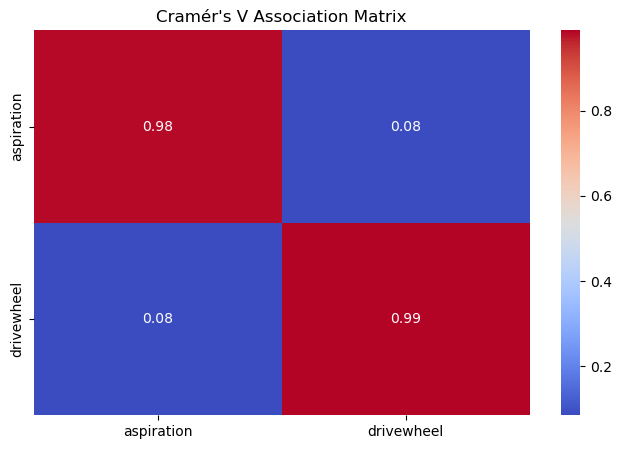

In [15]:
matrix=cramers_v_matrix(data,cat_cols)
plot_heatmap(matrix,cat_cols)

One hot encoding remaining categorical Variables

# Numerical eda

In [16]:
data[num_cols]

symboling,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price,cylindernumber,carbody,fuelsystem,enginetype
i64,f64,f64,f64,f64,i64,i64,f64,f64,f64,i64,i64,i64,i64,f64,i64,i64,i64,i64
3,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111,5000,21,27,13495.0,4,5,1,1
3,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111,5000,21,27,16500.0,4,5,1,1
1,94.5,171.2,65.5,52.4,2823,152,2.68,3.47,9.0,154,5000,19,26,16500.0,6,1,1,1
2,99.8,176.6,66.2,54.3,2337,109,3.19,3.4,10.0,102,5500,24,30,13950.0,4,3,1,1
2,99.4,176.6,66.4,54.3,2824,136,3.19,3.4,8.0,115,5500,18,22,17450.0,5,3,1,1
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
-1,109.1,188.8,68.9,55.5,2952,141,3.78,3.15,9.5,114,5400,23,28,16845.0,4,3,1,1
-1,109.1,188.8,68.8,55.5,3049,141,3.78,3.15,8.7,160,5300,19,25,19045.0,4,3,1,1
-1,109.1,188.8,68.9,55.5,3012,173,3.58,2.87,8.8,134,5500,18,23,21485.0,6,3,1,1


Univariate Analysis

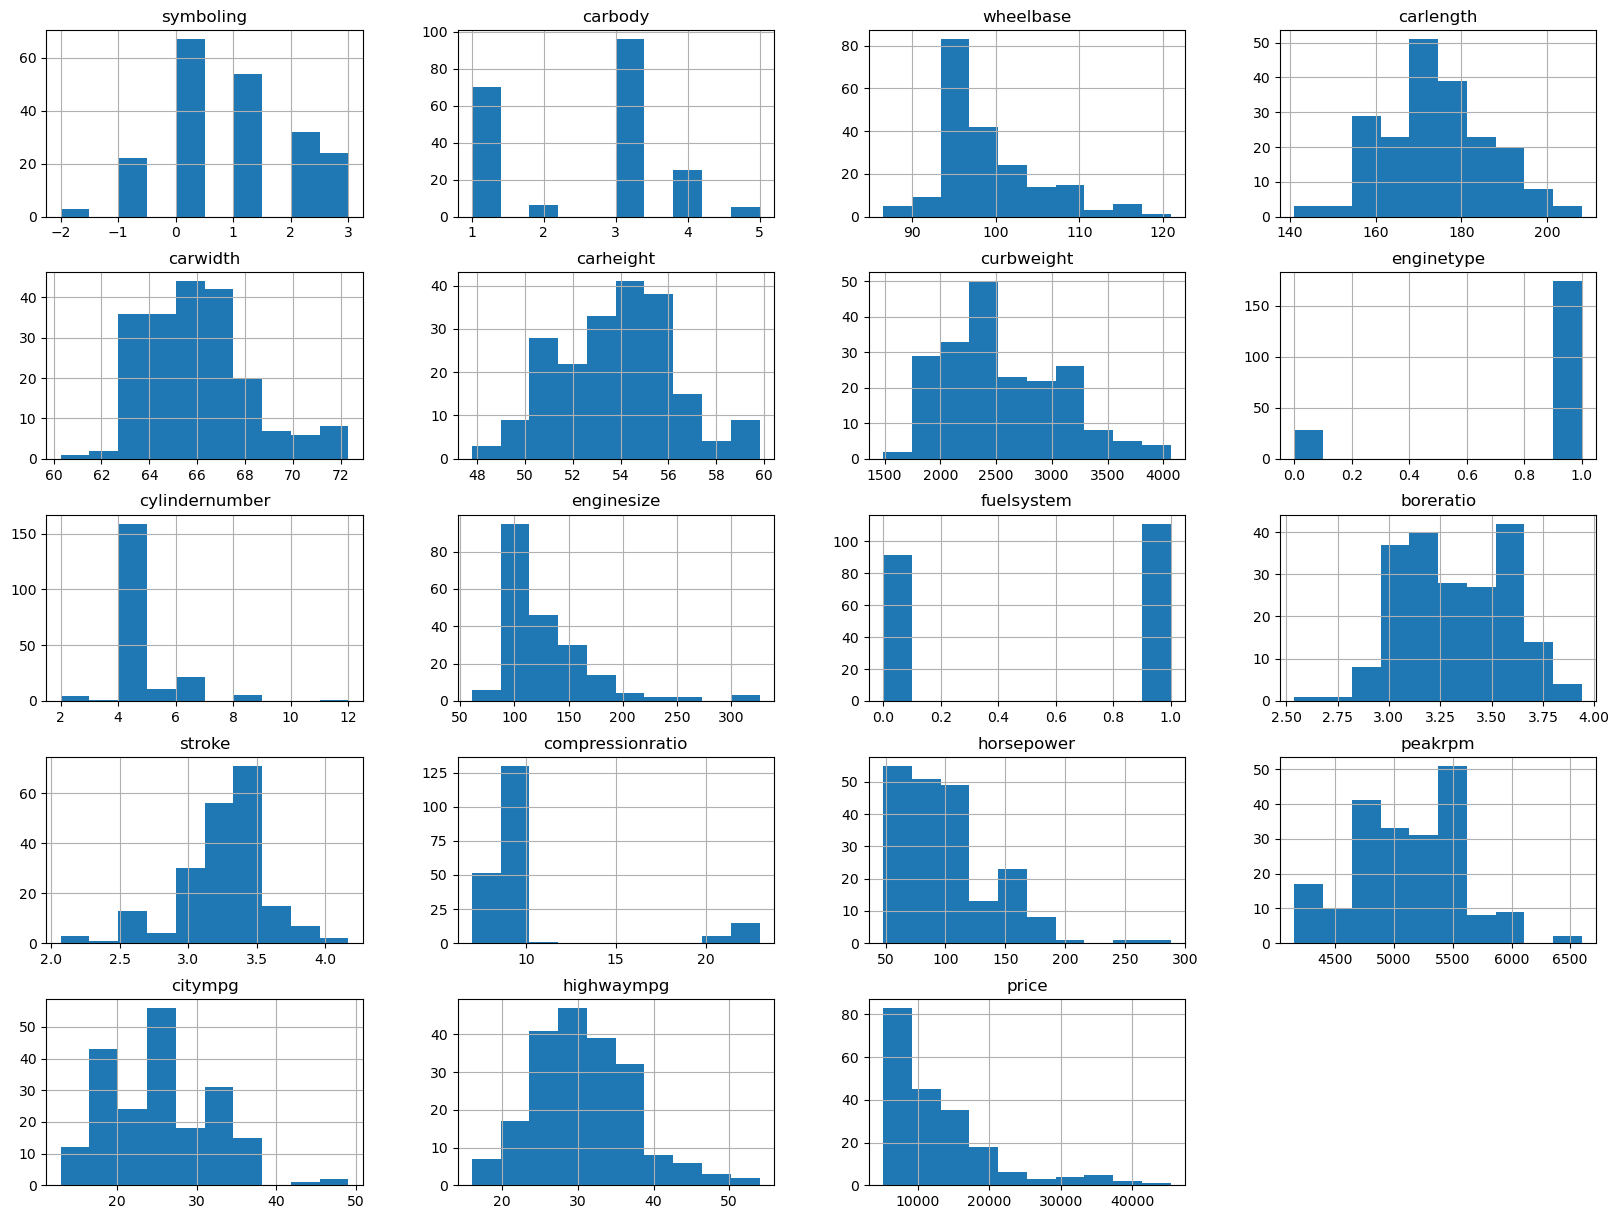

In [17]:
data.to_pandas().hist(bins=10,figsize=(20,15))
plt.show()

# Most features are roughly Normal some are Right skewed including the dependent variable "Price"

Bivariate Analysis

<Axes: >

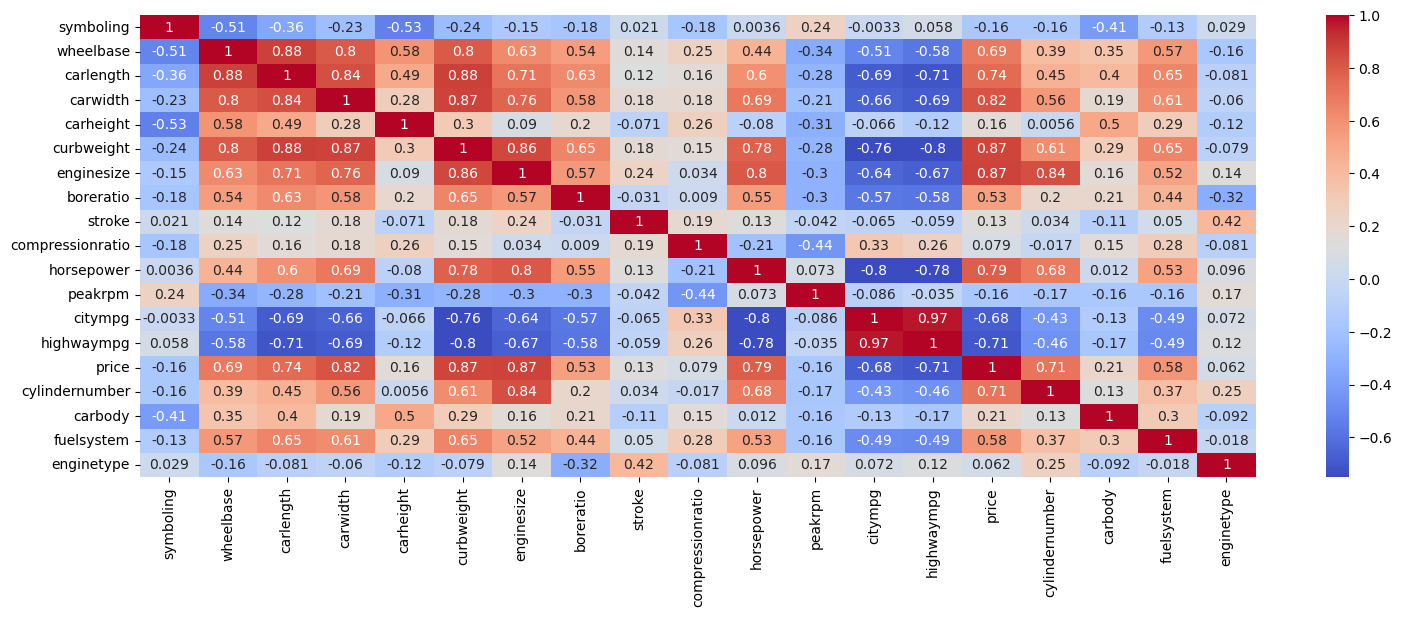

In [18]:
plt.figure(figsize=(18,6))
sns.heatmap(data[num_cols].to_pandas().corr(),annot=True,cmap="coolwarm",robust=True)

# Lot of Multi collinear features exists

Will deal with these multi collinear features based on modeling results

In [19]:
for i in cat_cols:
    print(data[i].value_counts())

shape: (2, 2)
┌────────────┬───────┐
│ aspiration ┆ count │
│ ---        ┆ ---   │
│ str        ┆ u32   │
╞════════════╪═══════╡
│ turbo      ┆ 37    │
│ std        ┆ 165   │
└────────────┴───────┘
shape: (2, 2)
┌────────────┬───────┐
│ drivewheel ┆ count │
│ ---        ┆ ---   │
│ str        ┆ u32   │
╞════════════╪═══════╡
│ fwd        ┆ 129   │
│ rwd        ┆ 73    │
└────────────┴───────┘


In [20]:
data=data.to_dummies(columns=cat_cols).drop(["aspiration_turbo","drivewheel_rwd"])
data.write_csv("../Day2_naive_modeling/preprocessed.csv")

Rough estimation of our data usefullness for linear regression

Test Scores: [0.49117655 0.84072664 0.84359816]
Training Scores: [0.91711393 0.9031102  0.89930425]
Mean Test Score: 0.7251671177839505
Standard Deviation of Test Scores: 0.16546046773001982
Mean absolute Error: 4182.798902713215
R-squared: 0.4633797777209826


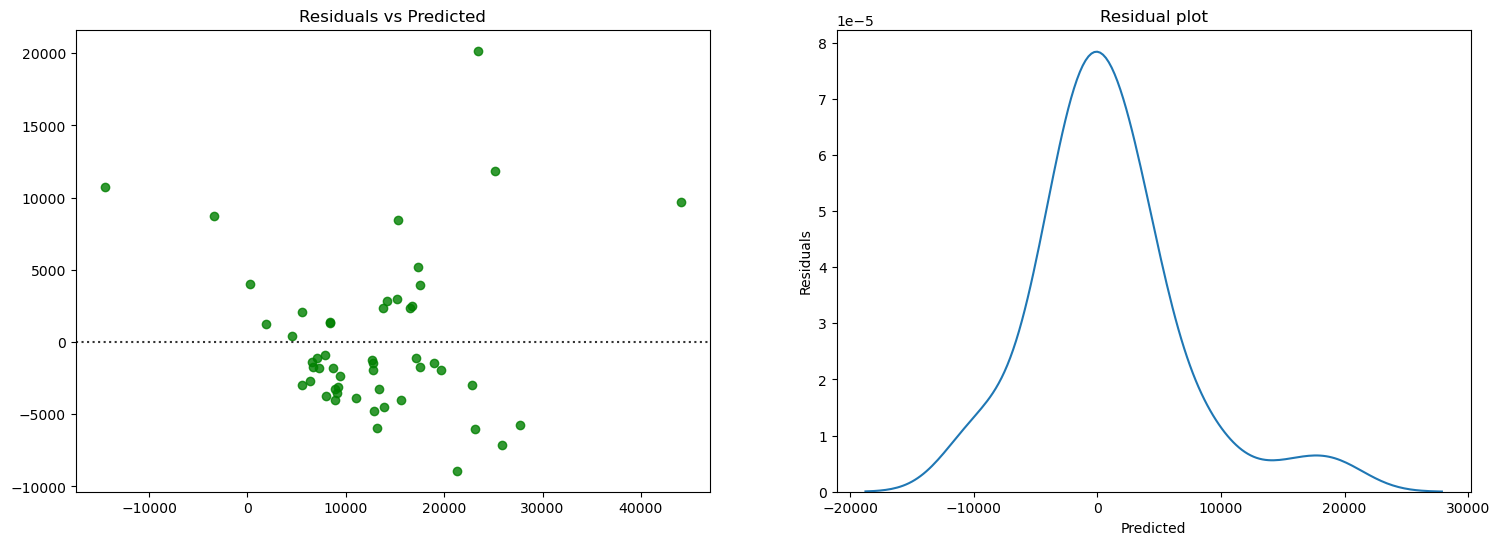

In [21]:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
X_train, X_test, y_train, y_test = train_test_split(data.drop("price"),data["price"],test_size=0.25,random_state=0)
lr=LinearRegression()

kf=KFold(n_splits=3)
cv_results = cross_validate(lr, X_train,y_train, cv=kf, scoring='r2', return_train_score=True)
print(f'Test Scores: {cv_results["test_score"]}')
print(f'Training Scores: {cv_results["train_score"]}')
print(f'Mean Test Score: {cv_results["test_score"].mean()}')
print(f'Standard Deviation of Test Scores: {cv_results["test_score"].std()}')

from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_absolute_error,r2_score

predictions = cross_val_predict(lr, X_test, y_test, cv=kf)
residuals = y_test - predictions
mse = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f'Mean absolute Error: {mse}')
print(f'R-squared: {r2}')

fig,[ax1,ax2] = plt.subplots(ncols=2,figsize=(18,6))
sns.residplot(x=predictions, y=residuals, color='g',ax=ax1)
plt.xlabel('Predicted')
plt.ylabel('Residuals')
ax1.set_title('Residuals vs Predicted')
sns.kdeplot(residuals,ax=ax2)
ax2.set_title("Residual plot")
plt.show()

# Starting mean absoulte error 4182

# insights : over fitting to train data and performing poor on test